Using integrals as a metric of contextual effects seem straightforward. Previous analysis has shown that both integral
and significant integral are closely correlated, so there is a value on using the later since its more robust to noise.
This approach has the shortcoming of not giving information about the temporal evolution of the contextual effects.
These are potential goals of this notebook:
1. Center of mass calculation
    1. for all bins? for significant bins!
2. Examples of cells from parameter space
3. train classifier + cross validation (optional, should go in another notebook?)
4. total integral/center-of-mass threshold (clean up memory less units)
    1.compare dPCA between full population vs filtered (context units)
5. classify probes by wave source (eg. ferret vocalizations)
6. baseline evoked activity threshold
    1. specific for context probe related activity (already in place?)
    2. in a probe specific manner
7. clean up probe quality
    1. treat different unit-probe combination as individual cells (collapse/mean across bigger population)
    2. filter out non responsive unit-probe combinations
8. Check spectrogram for responding units
    1. check and compare vs silence (silence as probe?)

In [1]:
import pathlib as pl
from configparser import ConfigParser
import itertools as itt
from textwrap import fill

import numpy as np
import pandas as pd
import scipy.stats as sst

import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import fancy_plots as fplt

from cpp_cache import set_name
import joblib as jl

from IPython import display
import ipywidgets as widgets

[nems.configs.defaults INFO] Saving log messages to /tmp/nems\NEMS 2020-10-14 162222.log


In [2]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)

## Proff of concept

Tests how to calculate the center of mass of any arbitrary vector.
The same equation is used in "cpn_batch_summary_metrics.py"

0.8255413950371603


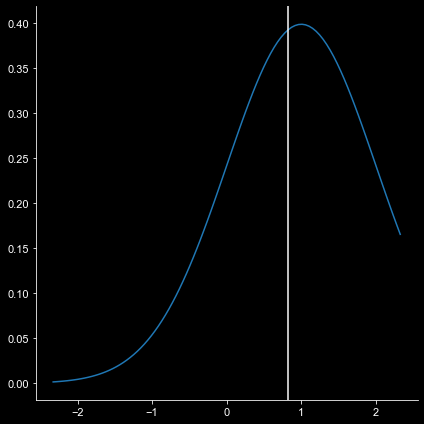

In [3]:
#toy example on how to calculate the center of mass.
def center_of_mass(values, times):
    return np.sum(values * times) / np.sum(values)

# generate some arbitrary data
x = np.linspace(sst.norm.ppf(0.01),
                sst.norm.ppf(0.99), 100)
y = sst.norm.pdf(x, 1, 1)

# calculates the center of mas
mass = center_of_mass(y, x)
print(mass)

# plots example
fig, ax = plt.subplots()
ax.plot(x, y)
ax.axvline(mass)
plt.show(fig)

In [4]:
# loads the summary metrics
config = ConfigParser()
if pl.Path('../context_probe_analysis/config/settings.ini').exists():
    config.read(pl.Path('../context_probe_analysis/config/settings.ini'))
elif pl.Path('../../../context_probe_analysis/config/settings.ini').exists():
    config.read(pl.Path('../../../context_probe_analysis/config/settings.ini'))
else:
    raise FileNotFoundError('config file could not be find')

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': ['silence', 'continuous', 'similar', 'sharp'],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'DF_summary' / set_name(meta)

DF = jl.load(summary_DF_file)
# todo recache DF
# DF['value'].fillna(DF['values'], inplace=True)
# DF.drop(['values'], axis=1, inplace=True)

## Application to data

Now plots the distribution of cells in the new parameter space, of particular interest is to compare how the old
parametric values (tau, r0) are related to the new non parametric values (center-of-mass and integral)

1. fisrt lets see howe the center of mass and its significant variant behave

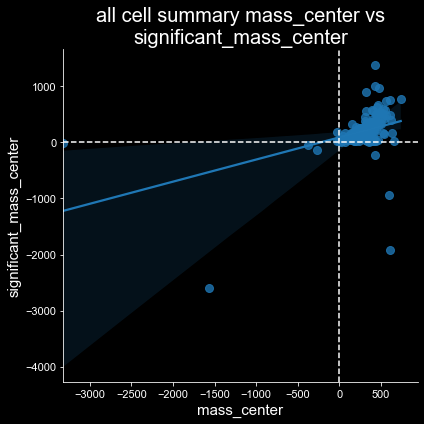

In [5]:
x = 'mass_center'
y = 'significant_mass_center'
ff_parameter = DF.parameter.isin([x, y])
ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'

filtered = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted)
ax.axhline(0, linestyle='--')
ax.axvline(0, linestyle='--')

title = 'all cell summary mass_center vs significant_mass_center'
ax.set_title(fill(title, 35))


plt.show(ax)

Clearly there is an issue with the center of mas calculation, which should nevere take negative values since its  units
are time in seconds after the onset of the probe sound. Since times can never get negatives values then the negative mass
center must come from a "negative mass" i.e negative d primes. then I need to use the absolute dprime values as I have
already done before for the integral

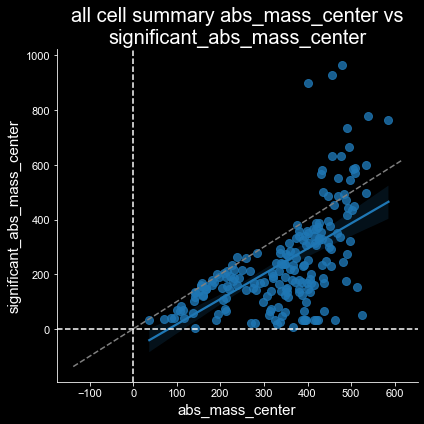

In [6]:
x = 'abs_mass_center'
y = 'significant_abs_mass_center'
ff_parameter = DF.parameter.isin([x, y])
ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'

filtered = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted)
ax.axhline(0, linestyle='--')
ax.axvline(0, linestyle='--')
fplt.unit_line(ax)


title = f'all cell summary {x} vs {y}'
ax.set_title(fill(title, 35))

plt.show(ax)

This deffinitely looks much better, but I dont trust the cells withe super high centers of mass regardless of
significance. Most likely these are cells with some random blips of significant contextual effects later on, but
significance does not mean a big effect size,
2. to check effect size amplitude, plot duration (center of mass) vs amplitude (integral)

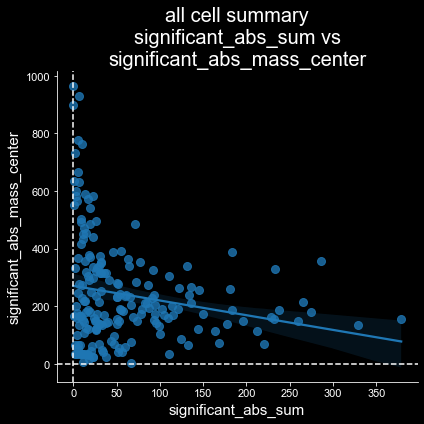

In [7]:
x = 'significant_abs_sum'
y = 'significant_abs_mass_center'
ff_parameter = DF.parameter.isin([x, y])
ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'

filtered = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted)
ax.axhline(0, linestyle='--')
ax.axvline(0, linestyle='--')

title = f'all cell summary {x} vs {y}'
ax.set_title(fill(title, 35))

plt.show(ax)

Now lets compare it with the old parameter space R0 Tau (both for the d-rpime value)

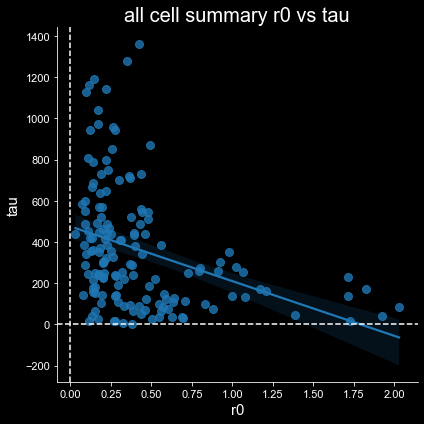

In [8]:
good_thresh = 0.1
x = 'r0'
y = 'tau'

ff_parameter = DF.parameter.isin([x, y])
ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'
ff_source = DF.source == 'dprime'
ff_good = DF.goodness > good_thresh

filtered = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted)
ax.axhline(0, linestyle='--')
ax.axvline(0, linestyle='--')

title = f'all cell summary {x} vs {y}'
ax.set_title(fill(title, 35))

plt.show(ax)

Finally, while there is a resemblance between the old parameter space and the new "non-parameter" space, we need to
compare directly the equivalents: Tau and center of mass; Integral and R0.

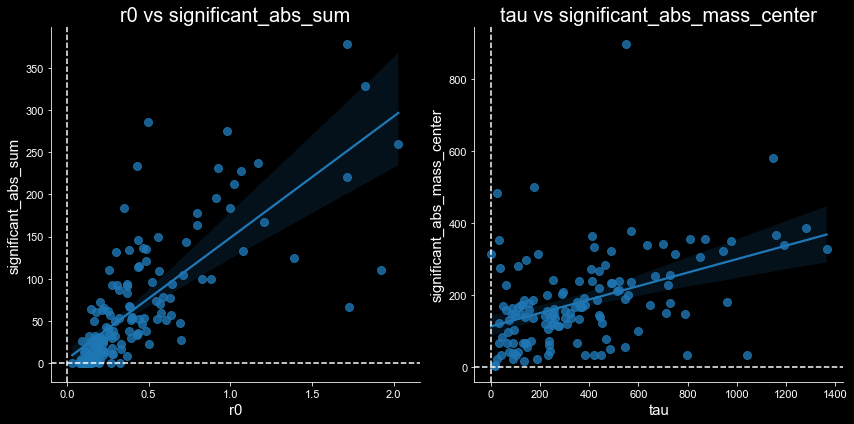

In [9]:
# make the comparisons in subplots
fig, axes = plt.subplots(1,2,squeeze=True)

# defines common filters
good_thresh = 0.1

ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'
ff_source = DF.source == 'dprime'
ff_good = np.logical_or(DF.goodness > good_thresh, DF.goodness.isnull())

# amplitude comparison
x = 'r0'
y = 'significant_abs_sum'
ff_parameter = DF.parameter.isin([x, y])

filtered = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted, ax=axes[0])

subtitle = f'{x} vs {y}'
ax.set_title(fill(subtitle, 35))

# duration comparison
x = 'tau'
y = 'significant_abs_mass_center'

ff_parameter = DF.parameter.isin([x, y])

filtered = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted, ax=axes[1])

subtitle = f'{x} vs {y}'
ax.set_title(fill(subtitle, 35))


for ax in axes:
    ax.axhline(0, linestyle='--')
    ax.axvline(0, linestyle='--')
fig.set_size_inches(12,6)
plt.show(fig)

We can question how adecuate are the values of significant_absolute sume and mass center given that they sin of multiple
comparisons. In particular imaging that a cell has a relatively big but non singificant contextual effect under probe 2,
and a small but significant contextual effect to probe 5. How thing are set up, if take the mean across probes, the non
significant effect will be averaged into what is called a significant mean effect.

to check whether this is the case and it is incovenient, it is worhthile comparing the new non-parameters to the r0 and
tau of the significance profile. I hope they are somewhat correlated

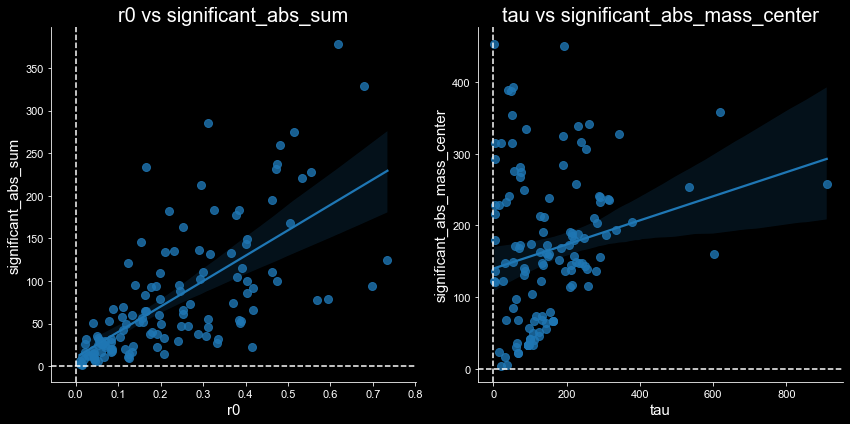

In [10]:
# make the comparisons in subplots
fig, axes = plt.subplots(1,2,squeeze=True)

# defines common filters
good_thresh = 0.1

ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'
ff_good = np.logical_or(DF.goodness > good_thresh, DF.goodness.isnull())

# fits to significance
ff_parameter = DF.parameter.isin(['tau', 'r0'])
ff_source = DF.source == 'significance'
signif_fits = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]

# non-parameter to dprime
ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_source = DF.source == 'dprime'
dprime_non_params = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]

wdf = pd.concat([signif_fits, dprime_non_params])

# amplitude comparison
x = 'r0'
y = 'significant_abs_sum'
ff_parameter = wdf.parameter.isin([x, y])

filtered = wdf.loc[ff_parameter, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted, ax=axes[0])

subtitle = f'{x} vs {y}'
ax.set_title(fill(subtitle, 35))

# duration comparison
x = 'tau'
y = 'significant_abs_mass_center'

ff_parameter = wdf.parameter.isin([x, y])

filtered = wdf.loc[ff_parameter, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted, ax=axes[1])

subtitle = f'{x} vs {y}'
ax.set_title(fill(subtitle, 35))


for ax in axes:
    ax.axhline(0, linestyle='--')
    ax.axvline(0, linestyle='--')
fig.set_size_inches(12,6)
plt.show(fig)

**in conconclussion:**
1. the non parametric approach (new) recapitulates the parametric one (old).
2. taking the mean over dprimes and calling it significant based on the mean of the significances, while fishi (still
needs multiple comparisons correction) seems to be fine for now

The choice of which one to use lies on the "better explanation power" and less asumptions of the nonparametric approach. it is
interesting that the significan absolute mass center seems to have a limit around 400 ms (regardless of the tau value).

## treatment comparisons

Now lets see how the two new parameters change as a function of context pair and probe

In [26]:
@widgets.interact(parameter=['significant_abs_sum', 'significant_abs_mass_center'],
                  compare=widgets.fixed('transition_pair'),
                  analysis=widgets.fixed('SC'),
                  source=widgets.fixed('dprime'))
def condition_effect_on_parameter(parameter='significant_abs_mass_center',
                                  compare='transition_pairs',
                                  analysis='SC',
                                  source='drpime'):
    if compare == 'probe':
        ff_probe = DF.probe != 'mean'
        ff_trans = DF.transition_pair == 'mean'
    elif compare == 'transition_pair':
        ff_probe = DF.probe == 'mean'
        ff_trans = DF.transition_pair != 'mean'

    if analysis == 'SC':
        index = 'cellid'
    elif analysis in ('dPCA', 'LDA'):
        index = 'siteid'


    ff_analisis = DF.analysis == analysis
    ff_parameter = DF.parameter == parameter
    ff_source = DF.source == source
    ff_value = DF.value > 0

    filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_value,
                      [index, compare, 'goodness', 'value']]
    pivoted = filtered.pivot(index=index, columns=compare, values='value').dropna().reset_index()
    molten = pivoted.melt(id_vars=index, var_name=compare)

    fig, ax = plt.subplots()
    # _ = fplt.paired_comparisons(ax, data=molten,x=compare, y='value', color='gray', alpha=0.3)
    ax = sns.boxplot(x=compare, y='value', data=molten, ax=ax, color='white', width=0.5)
    sns.despine(ax=ax)

    # no significant comparisons
    box_pairs = list(itt.combinations(filtered[compare].unique(), 2))
    stat_resutls = fplt.add_stat_annotation(ax, data=molten, x=compare, y='value', test='Wilcoxon',
                                       box_pairs=box_pairs, width=0.5, comparisons_correction=None)

    if parameter == 'significant_abs_sum':
        ylabel = 'context integral (ms * dprime)'
    elif parameter == 'significant_abs_mass_center':
        ylabel = 'center of mass (ms)'
    else:
        ylabel = 'value'
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


    fig = ax.figure
    title = f'{analysis} {source}-{parameter} between {compare} {len(pivoted.index)}units'
    ax.set_title(fill(title, 35))
    fplt.savefig(fig, 'WIP4_figures', title, type='svg')
    fplt.savefig(fig, 'WIP4_figures', title, type='png')
    plt.show(fig)
    return fig, ax

A Jupyter Widget

### context pair effect
as seen from above the context pair are realated to different amounts of contextual effects, seen both in the integral
and center of mass. The trend shows reduced differences for the continuous and similar pair, and this effect is more
evident for the center of mass than for the integral.

I might be worthwhile normalizing these values to compare betweeen the two...

If we consider the contextual effects seen for probes presented to the same cell as if they were different cells we can
increase the amount of data.

In [30]:
# # for single plot
parameter = 'significant_abs_mass_center'

good_thresh = 0.1 # unused for non-parametric values
analysis = 'SC'
source = 'dprime'

ff_probe = DF.probe != 'mean'
ff_trans = DF.transition_pair != 'mean'

if analysis == 'SC':
    index = 'cellid'
elif analysis in ('dPCA', 'LDA'):
    index = 'siteid'


ff_analisis = DF.analysis == analysis
ff_parameter = DF.parameter == parameter
ff_source = DF.source == source
ff_value = DF.value > 0

filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_value, :]
                  # [index, 'probe', 'transition_pair', 'goodness', 'value']]
print(filtered.head(10))

Empty DataFrame
Columns: [siteid, cellid, analysis, source, probe, transition_pair, parameter, std, goodness, value, region]
Index: []


In [ ]:
filtered['index_probe'] = filtered[[index, 'probe']].agg('_'.join, axis=1)

pivoted = filtered.pivot(index='index_probe', columns='transition_pair', values='value').dropna().reset_index()
molten = pivoted.melt(id_vars='index_probe', var_name='transition_pair')

fig, ax = plt.subplots()
# _ = fplt.paired_comparisons(ax, data=molten,x=compare, y='value', color='gray', alpha=0.3)
ax = sns.boxplot(x='transition_pair', y='value', data=molten, ax=ax, color='white', width=0.5)
sns.despine(ax=ax)

# no significant comparisons
box_pairs = list(itt.combinations(filtered[compare].unique(), 2))
stat_resutls = fplt.add_stat_annotation(ax, data=molten, x=compare, y='value', test='Wilcoxon',
                                   box_pairs=box_pairs, width=0.5, comparisons_correction=None)

if parameter == 'significant_abs_sum':
    ylabel = 'context integral (ms * dprime)'
elif parameter == 'significant_abs_mass_center':
    ylabel = 'center of mass (ms)'
else:
    ylabel = 'value'
ax.set_ylabel(ylabel)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


fig = ax.figure
title = f'{analysis} {source}-{parameter} between {compare} {len(pivoted.index)}units'
ax.set_title(fill(title, 35))
fplt.savefig(fig, 'WIP4_figures', title, type='svg')
fplt.savefig(fig, 'WIP4_figures', title, type='png')
plt.show(fig)


### Probe effect
Since there is no systematic selection of probes, the categories are arbitrary and mix of sounds. Any significant effect
here is happening by random chance...

An alternative is to quantify the overall variance between probes for each cell.

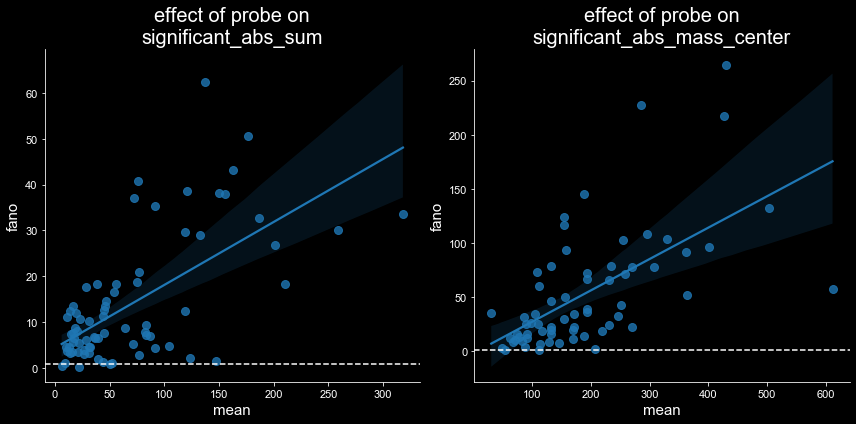

In [18]:
fig, axes = plt.subplots(1,2, squeeze=True)

# common filters
good_thresh = 0.1

ff_probe = DF.probe != 'mean'
ff_trans = DF.transition_pair == 'mean'
ff_source = DF.source == 'dprime'
ff_good = np.logical_or(DF.goodness > good_thresh, DF.goodness.isnull())
ff_value = DF.value > 0
ff_analisis = DF.analysis == 'SC'

# integral
parameter = 'significant_abs_sum'
ff_parameter = DF.parameter == parameter

filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_good & ff_value,
                  ['cellid', 'probe', 'goodness', 'value']]
pivoted = filtered.pivot_table(index=['cellid'], columns='probe', values='value').dropna().reset_index()
pivoted['mean'] = pivoted.mean(axis=1)
pivoted['var'] = pivoted.var(axis=1)
pivoted['fano'] = pivoted['var']/pivoted['mean']
ax = sns.regplot(x='mean', y='fano', data=pivoted, ax= axes[0])
ax.set_title(fill(f'effect of probe on {parameter}', 35))

# center of mass
parameter = 'significant_abs_mass_center'
ff_parameter = DF.parameter == parameter

filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_good & ff_value,
                  ['cellid', 'probe', 'goodness', 'value']]
pivoted = filtered.pivot_table(index=['cellid'], columns='probe', values='value').dropna().reset_index()
pivoted['mean'] = pivoted.mean(axis=1)
pivoted['var'] = pivoted.var(axis=1)
pivoted['fano'] = pivoted['var']/pivoted['mean']
ax = sns.regplot(x='mean', y='fano', data=pivoted, ax= axes[1])
ax.set_title(fill(f'effect of probe on {parameter}', 35))

for ax in axes:
    ax.axhline(1, linestyle='--')

fig.set_size_inches(12,6)

plt.show(fig)

interestingly there is a liner increase of std with the mean. Indeed the fano factor seems to be >1 for most cells and
further increasing with the mean. This over-dispersion can be interpreted as clumpiness in the context effects withing
probe space i.e context effects are highly dependent on probes, e.g. for a given cell, contextual effects will be big for
one sound but small for a different sound